# Продвинутый Python, семинар 5

**Лектор:** Петров Тимур

**Семинаристы:** Бузаев Федор, Дешеулин Олег, Васина Олеся, Коган Александра, Садуллаев Музаффар

**Spoiler Alert:** в рамках курса нельзя изучить ни одну из тем от и до досконально (к сожалению, на это требуется больше времени, чем даже 3 часа в неделю). Но мы попробуем рассказать столько, сколько возможно :)




## Идея! [Напоминание с лекции]

Мы тратили какое-то время на то чтобы поднимать процессы, потоки, а что если не поднимать ничего?!

Давайте представим себе программу которая умеет "переключать внимание" пока какие-то долгие операции выполняются. В целом в этом "переключении внимания" с помощью механизма eventов и состоит смысл coroutine и asyncio.

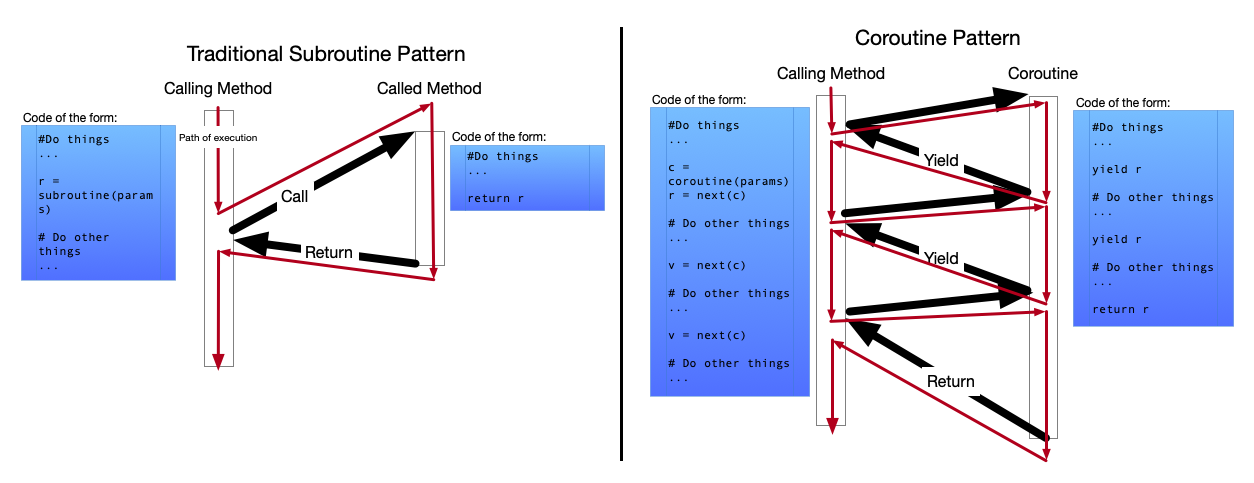

Обратите внимания что здесь нет как таковой многопоточности или подпроцессов. Предпологается, что переключение внимания происходит в рамках одного процесса, в то время как какие-то другие, асинхронные с питоном процессы делают что-то и возвращают результат этого собственно питону. Примеры таких процессов:

* Прием/отправка чего-либо по сети
* Запись/чтение с диска (и соотвественно DB)
* RPC/gRPC (remote procedure call) вызовы другой программы

Какие приложения тогда стоит и не стоит писать с помощью asyncio?

* приложение в котором происходят любые вычисления внутри python, скажем рисование на картинке или проставление запятых в текстах - плохо подходит для этого. Что лучше использовать тогда, кстати говоря? Подсказка: GIL.
* приложение в котором много запросов к сети и сохранение на диск, скажем web-scrapper - отлично подходит
* типичный микросервис, который ходит к базе данных, смотрит что-то и отвечает по сети - идеальный кейс для asyncio
* телеграм-бот

Почему это может быть лучше чем использование thread (потоков):

* Быстрее переключение контекста
* Не нужно менеджерить ничего, все что shared - shared, код работает нативно, нужно только расставить await/async (почти)


Минусы:
* В библиотеке которой вы пользуетесь должна быть поддержка asyncio. Иначе придется позвать thread на помощь
* Вычислительные задачи нельзя распраллелить (как и нельзя было в случае с потоками)

In [ ]:
!pip install fastapi uvicorn aioschedule telebot

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for aioschedule: filename=aioschedule-0.5.2-py3-none-any.whl size=8481 sha256=830bff4629a1a35335d187160ad7439def3f93ea4feb1ae408e81db70940d1f2
  Stored in directory: /root/.cache/pip/wheels/f5/b2/2a/ee29c2ee340b4c4552cda20998765a51eb48563c97c2bb2577
  Created wheel for pyTelegramBotAPI: filename=pyTelegramBotAPI-4.14.0-py3-none-any.whl size=215250 sha256=1c33b02f6f2e0517a9abceafc2eec6bcce1826a494143a57fd483d3bc3eb1328
  Stored in directory: /root/.cache/pip/wheels/25/51/2d/24b40a366c85c37928d5aa36ddf257e5a79fad25e1ecd11b2c
Successfully built aioschedule pyTelegramBotAPI


## Roadmap работы с асинхронными функциями



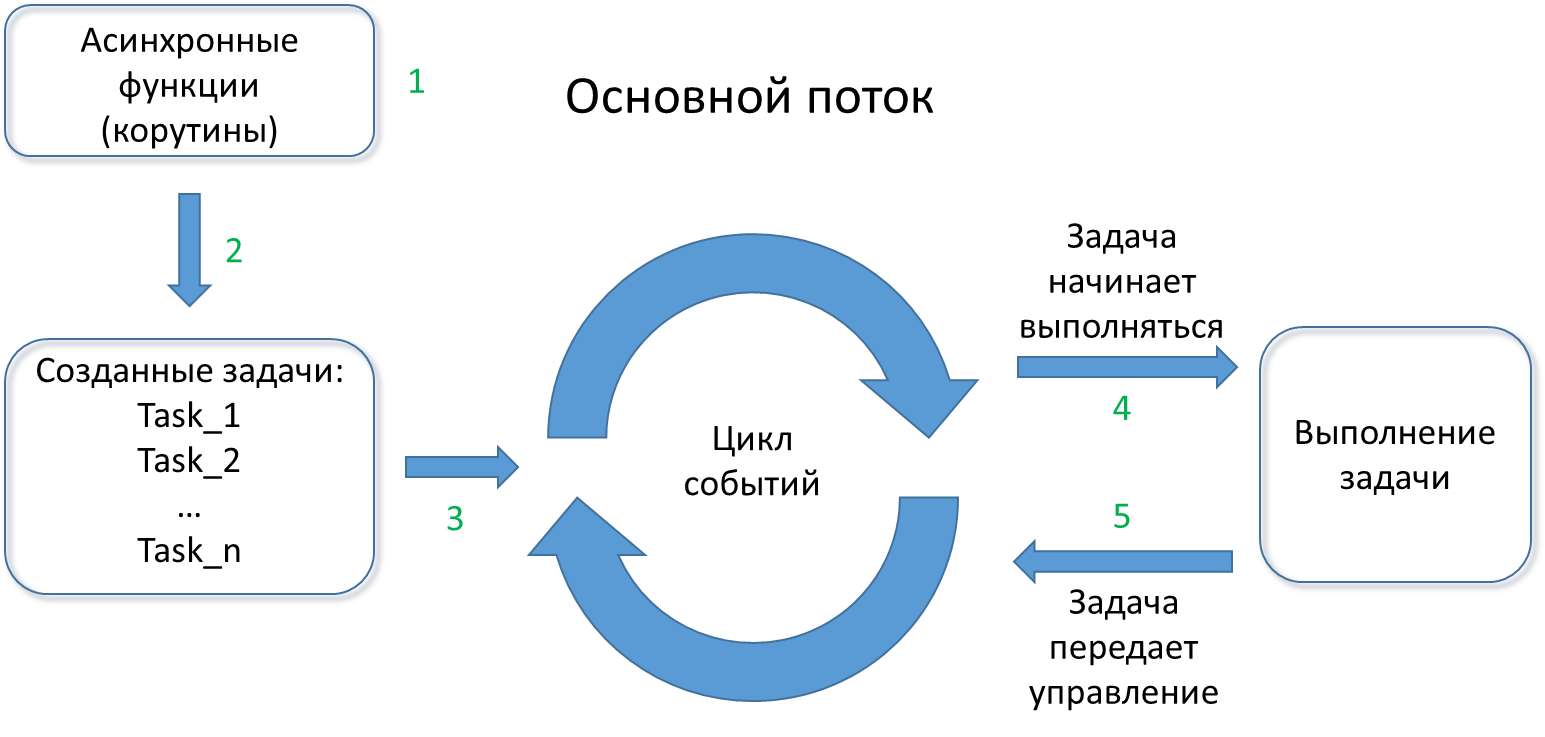

Как мы уже говорили, стандартное приложение с использованием asyncio выполняется в одном потоке.

1. Сначала нам нужно определить асинхронные функции - корутины (coroutine), которые будут реализовывать какую-то логику, связанную с использованием операций ввода/вывода.   
2. Из данных корутин нужно создать задачи (Task). Количество задач для каждой корутины определяется целями вашего приложения.
3. Данные задачи попадают в цикл событий (event loop), который отвечает за выполнение всех запланированных задач.
4. Одна из задач начинает свое выполнение.
5. Задача выполняется до тех пор пока она не передаст управление обратно в цикл событий. После этого цикл событий отдаст управление другой задаче. Передача управления обратно в цикл событий может произойти в двух случаях:

    5.1. задача завершена
    
    5.2. задача приостановлена, так как она отправила асинхронный запрос и ожидает ответ

Такая смена управления между задачами внутри цикла событий происходит до тех пор, пока все запланированные задачи не будут выполнены. После этого цикл событий завершит свою работу.

## Работаем с Asyncio [Напоминание с лекции]

Немного синтаксиса:

* `async def`: cинтаксис для создания асинхронной функции.
* `async with`: cинтаксис для создания асинхронного контекста (что угодно).
* `async for`: cинтаксис для итерирования по асинхронному генератору (пример будет позже)
* `await <name>`: синтаксис отвечающий за то чтобы подождать что-то асинхронное

Корутины — это функции, которые можно приостанавливать и возобновлять. Они позволяют управлять моментами остановки и продолжения выполнения, что делает их полезными в асинхронном программировании, например, для длительных операций, ожидания данных от внешних источников или работы с другими корутинами.

In [ ]:
async def print_numbers():
    for i in range(10):
        print(i)
        await asyncio.sleep(0.25)

In [ ]:
# если бы мы были не в jupyter notebook:
# asyncio.run(print_numbers())
# но jupyter notebook уже поднимает event loop внутри себя (скоро узнаем что это), когда запускает интерпретатор...
await print_numbers()

0
1
2
3
4
5
6
7
8
9


Корутины работают по принципу *кооперативной многозадачности*, в отличие от *вытесняющей многозадачности*, используемой в потоках. Это означает, что корутины самостоятельно передают управление обратно в цикл событий. Если корутина не передаст управление, она будет выполняться до завершения.

В кооперативной многозадачности задачи сами решают, когда передать управление другим. То есть каждая задача должна добровольно уступить контроль, чтобы другие могли выполняться.

## Tasks

Создание и запуск задачи. Метод `asyncio.create_task()`.

Задачи представляют собой обертки для корутин и используются для их конкурентного выполнения. Для создания задачи используется функция `asyncio.create_task()`.

Давайте проверим что функции действительно не блокируют друг друга:

In [ ]:
import asyncio

async def fetch_data():
    print('start fetching')
    await asyncio.sleep(2) # pause for 2 seconds
    print('done fetching')
    return "data"

async def print_numbers():
    for i in range(10):
        print(i)
        await asyncio.sleep(0.25)

async def main():
    task1 = asyncio.create_task(fetch_data())
    task2 = asyncio.create_task(print_numbers())
    print("Таска1:", task1)
    value = await task1
    print("Дата", value)
    print("Таска2:", task2)
    await task2
    print("а теперь таска1", task1)
    print("а теперь таска2:", task2)

In [ ]:
# если бы мы были не в jupyter notebook:
# asyncio.run(main())
# но jupyter notebook уже поднимает event loop внутри себя (скоро узнаем что это), когда запускает интерпретатор...
await main()

Таска1: <Task pending name='Task-8' coro=<fetch_data() running at <ipython-input-5-45cc4b9020b1>:3>>
start fetching
0
1
2
3
4
5
6
7
done fetching
Дата data
Таска2: <Task pending name='Task-9' coro=<print_numbers() running at <ipython-input-5-45cc4b9020b1>:12> wait_for=<Future pending cb=[Task.task_wakeup()]>>
8
9
а теперь таска1 <Task finished name='Task-8' coro=<fetch_data() done, defined at <ipython-input-5-45cc4b9020b1>:3> result='data'>
а теперь таска2: <Task finished name='Task-9' coro=<print_numbers() done, defined at <ipython-input-5-45cc4b9020b1>:9> result=None>



> Обратите внимание что print task ничего не блокирует. Однако, принт про вторую таску произошел после конца первой, потому что перед ним был await.

Давайте убедимся что мы действительно имеем дело c недетерминированными результатами, точно так же как и в реальном вызове многопоточности:

In [ ]:
async def add(x: int, y: int):
    return x + y

async def get_results():
    inputs = [(2,3), (4,5), (5,5), (7,2)]
    # создали список корутин
    cors = [add(x,y) for x,y in inputs]

    # в этом лупе корутины yield как только заканчиваются
    for cor in asyncio.as_completed(cors):
        print(await cor)

In [ ]:
await get_results()

9
10
9
5


In [ ]:
await get_results()

9
5
9
10


## Как это работает внутри питона?

Уже до этого упоминались какие-то event loop и переключения между тасками. Давайте обсудим что это.



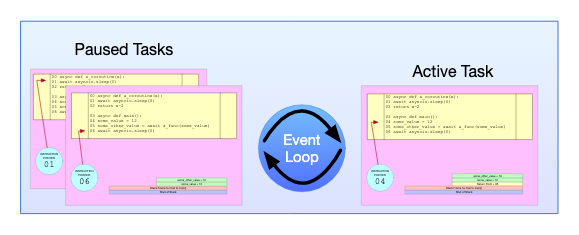

#### Кто такой этот ваш yield?

`yield` это механизм создания генератора. Генератор это ленивый итерируемый объект. Каждый его следующий элемент вычисляется только тогда когда мы зовем метод `next()`.

Когда функция содержит оператор `yield`, она становится генератором. Когда генератор вызывается, он возвращает объект-генератор без фактического выполнения кода внутри функции (поэтому `while True` не блокирует нас).

Каждый вызов метода `next()` на этом объекте-генераторе запускает выполнение кода в функции до тех пор, пока не встретится оператор `yield`. Значение, переданное в `yield`, возвращается как результат вызова `next()`, и выполнение функции приостанавливается до следующего вызова `next()`.

In [ ]:
from time import sleep

def yeilder():
    yield "item 1"
    yield "item 2"
    # откоментируй меня и запусти еще раз и сравни разницу
    # yield from run()

def run():
    while True:
        yield "item 3"
        yield from yeilder()
        yield "item 4"

In [ ]:
core = run()

In [ ]:
for i, item in enumerate(core):
  sleep(0.1)
  print(f"{i}: {item}")
  if i > 15:
      break

0: item 3
1: item 1
2: item 2
3: item 4
4: item 3
5: item 1
6: item 2
7: item 4
8: item 3
9: item 1
10: item 2
11: item 4
12: item 3
13: item 1
14: item 2
15: item 4
16: item 3


Позвать один раз генератор:

In [ ]:
next(core)

'item 1'

#### И причем здесь корутины и кто же этот ваш event loop??

Цикл событий (event loop) — это основа асинхронного программирования. Представьте его как простой цикл, работающий в одном потоке, который управляет задачами. Он отслеживает, когда каждая задача должна начаться, и запускает её в нужный момент. Это упрощает и делает предсказуемой работу кода, исключая хаос от множества одновременно выполняющихся операций.

Цикл событий управляет всеми задачами и, когда какая-то из них готова к выполнению, запускает её. Это позволяет эффективно распределять задачи, не дожидаясь завершения одной для начала другой.

In [ ]:
import time
import random

def countdown(task_id, n):
    while n > 0:
        yield n
        n -= 1
        time.sleep(0.5)
    print(f'{task_id} finished!')

def event_loop():
    tasks = [countdown(0, 10), countdown(1, 5), countdown(2, 7)]
    while tasks:
        task_id = random.randint(0, len(tasks) - 1)
        task = tasks[task_id]
        try:
            x = next(task)
            print(f'{task_id} finished!')
        except StopIteration:
            tasks.remove(task)

event_loop()

res from 1 = 5
res from 0 = 10
res from 2 = 7
res from 2 = 6
res from 1 = 4
res from 0 = 9
res from 1 = 3
res from 1 = 2
res from 1 = 1
1 finished!
res from 0 = 8
res from 1 = 5
res from 1 = 4
res from 1 = 3
res from 1 = 2
res from 1 = 1
res from 0 = 7
res from 0 = 6
1 finished!
res from 0 = 5
res from 0 = 4
res from 0 = 3
res from 0 = 2
res from 0 = 1
0 finished!


Отлично, пока мы ждем yeild мы умеем переключаться между тасками...

In [ ]:
async def add(x: int, y: int):
    return x + y

In [ ]:
type(add)

function

In [ ]:
coro = add(1, 2)

In [ ]:
type(coro)

coroutine

In [ ]:
coro.send, coro.throw

(<function coroutine.send>, <function coroutine.throw>)

In [ ]:
type(yeilder)

function

In [ ]:
type(core)

generator

In [ ]:
core.send, core.throw

(<function generator.send>, <function generator.throw>)

Пупупу... Совпадение - не думаю... И действительно - это не совпадение, корутины это во многом те же самые генераторы, запущенные тум самым event loop так чтобы некоторый набор специальный операций выполнялся не блокируя сам себя.

Например выше была проблема - мы спали в наших генераторах по-настоящему :(
Надо сделать сон и io не блокирующими и в целом получим asyncio.

## Виртуальный сон и наш личный event_loop

Что же делает send?

In [ ]:
async def add(x: int, y: int):
    print(x + y)
    return x + y

In [ ]:
coro = add(1, 2)

In [ ]:
try:
    print(coro.send(None))
except StopIteration:
    print('StopIteration')

3
StopIteration


`send` делает тож самое что и для генератора - запускает его до следующего yield или до момента пока у нас закончится



Отлично, кажется у нас собралось понимание как работает asyncio, напишем сами event loop тогда!

Напоминание: event loop призван крутить все корутины внутри себя.

In [ ]:
import datetime
import heapq
import types
import time


class Task:

    """
    Нам нужна обертка, которая будет хранить все информацию о том
    сколько именно нам нужно сдать до момента пока корутина закончится.

    Сравнения нам нужны чтобы воспользоваться потом кучей без попаболи.

    Это примерно тож самое что и asyncio.Task
    """

    def __init__(self, wait_until, coro):
        self.coro = coro
        self.waiting_until = wait_until

    def __eq__(self, other):
        return self.waiting_until == other.waiting_until

    def __lt__(self, other):
        return self.waiting_until < other.waiting_until

In [ ]:
from types import coroutine

# старый способ создавать корутины, из питона 3.4
# как видите по сути это тот же самый генератор с yield
@coroutine
def sleep(seconds):
    """Приостанавливаем корутину на seconds секунд

    Это будет наша переимплементация asyncio.sleep()
    """
    now = datetime.datetime.now()
    wait_until = now + datetime.timedelta(seconds=seconds)
    # Приостановлив выполнение всех других корутин в стеке вызовов
    actual = yield wait_until
    # продолжаем выполнение со стека вызов
    return actual - now

# обычная корутина, привычная глазу
async def countdown(label, length, *, delay=0):
    print(label, 'waiting', delay, 'seconds before starting countdown')
    delta = await sleep(delay)
    print(label, 'starting after waiting', delta)
    while length:
        print(label, 'T-minus', length)
        waited = await sleep(1)
        length -= 1
    print(label, 'lift-off!')

Напишем event loop который поддерживает скедулинг таких "спящих" тасок.

In [ ]:
class SleepingLoop:
    def __init__(self, *coros):
        self._new = coros
        self._waiting = []

    def run_until_complete(self):
        # Запускаем все наши корутины
        for coro in self._new:
            wait_for = coro.send(None)
            heapq.heappush(self._waiting, Task(wait_for, coro))
        # Пока есть корутины ранимся
        while self._waiting:
            now = datetime.datetime.now()
            # Забираем ближайшую корутину
            task = heapq.heappop(self._waiting)
            if now < task.waiting_until:
                # ждем если надо
                delta = task.waiting_until - now
                time.sleep(delta.total_seconds())
                now = datetime.datetime.now()
            try:
                # Время запустить её до следующего yield
                wait_until = task.coro.send(now)
                heapq.heappush(self._waiting, Task(wait_until, task.coro))
            except StopIteration:
                # Эта корутина все
                pass

In [ ]:
loop = SleepingLoop(countdown('A', 5), countdown('B', 3, delay=2),
                    countdown('C', 4, delay=1))
start = datetime.datetime.now()
loop.run_until_complete()
print('Total elapsed time is', datetime.datetime.now() - start)

A waiting 0 seconds before starting countdown
B waiting 2 seconds before starting countdown
C waiting 1 seconds before starting countdown
A starting after waiting 0:00:00.001902
A T-minus 5
C starting after waiting 0:00:01.001124
C T-minus 4
A T-minus 4
B starting after waiting 0:00:02.001104
B T-minus 3
C T-minus 3
A T-minus 3
B T-minus 2
C T-minus 2
A T-minus 2
B T-minus 1
C T-minus 1
A T-minus 1
B lift-off!
C lift-off!
A lift-off!
Total elapsed time is 0:00:05.008718


Более того, если вы думаете что внутри настоящего питона все совсем не так... То вы правы, выглядит сложнее, но суть та же: https://github.com/python/cpython/blob/304a1b3f3a8ed9a734ef1d098cafccb6725162db/Lib/asyncio/selector_events.py#L1205C5-L1205C20

Вы думаете писать свой личный event loop это моветон? Не-не, это стиль! Например очень популярная библиотека это ускоренный event loop питона: [uvloop](https://github.com/MagicStack/uvloop):


```
import asyncio
import sys

import uvloop

async def main():
    # Main entry-point.
    ...

if sys.version_info >= (3, 11):
    with asyncio.Runner(loop_factory=uvloop.new_event_loop) as runner:
        runner.run(main())
else:
    uvloop.install()
    asyncio.run(main())
```



Еще напрашивается вопрос: а что если мы не знаем сколько ждать...
Для этого используется немного другой механизм, который по сути позволяет выбирать между разными операциями ввода и вывода и делает polling их текущего статуса.

## Жизненые примеры



### CPU-heavy, неправильное использование корутины

https://mecha-mind.medium.com/understanding-why-you-wont-need-python-coroutines-99-9-of-the-time-fbb7ac60884d

Давайте возьмем какую-то жутко непонятную имплементацию расстояния Левенштейна (количества отличающихся символов в строках) и даже не будем в нее вникать, просто распараллелим с корутинами!

In [ ]:
# Compute levenshtein distance between str1 and str2
def edit_distance(str1:str, str2:str)->int:
    d:list = [[float("Inf")]*len(str2) for j in range(len(str1))]

    for i in range(len(str1)):
        for j in range(len(str2)):
            if i == 0 and j == 0:
                d[i][j] = 1 if str1[i] != str2[j] else 0
            elif i == 0:
                d[i][j] = d[i][j-1] + 1 if str1[i] != str2[j] else d[i][j-1]
            elif j == 0:
                d[i][j] = d[i-1][j] + 1 if str1[i] != str2[j] else d[i-1][j]
            else:
                if str1[i] == str2[j]:
                    d[i][j] = d[i-1][j-1]
                else:
                    d[i][j] = 1 + min(d[i-1][j-1], d[i-1][j], d[i][j-1])

    return d[-1][-1]

In [ ]:
strings = [
    "I love python course" * 30,
    "I love to study" * 30,
    "I love Higher school of economics" * 30,
    "Kto ya?" * 30
]

In [ ]:
import time
import asyncio

async def calc_and_send(str1, str2):
    res = edit_distance(str1, str2)
    # симулируем отправку результата по сети куда-то
    await asyncio.sleep(0.1)
    return res

def calc_and_send_sync(str1, str2):
    res = edit_distance(str1, str2)
    # симулируем отправку результата по сети куда-то
    time.sleep(0.1)
    return res

In [ ]:
start_time = time.time()
dist_matrix = []
for i in range(len(strings)):
    for j in range(len(strings)):
        dist_matrix.append(asyncio.create_task(calc_and_send(strings[i], strings[j])))
loop = asyncio.get_event_loop()
for item in asyncio.as_completed(dist_matrix):
    await item
time.time() - start_time

4.8727757930755615

In [ ]:
import multiprocessing as mp

In [ ]:
start_time = time.time()
dist_matrix = []
for i in range(len(strings)):
    for j in range(len(strings)):
        dist_matrix.append(mp.Process(target=calc_and_send_sync, args=(strings[i], strings[j])))
        dist_matrix[-1].start()
for proc in dist_matrix:
    proc.join()
time.time() - start_time

3.557293653488159

Как так??

Важно помнить!
Чтобы использование корутин было и по вкусу вкусно и по сути необходимо:
* IO-bounded приложение
* Библиотека которой вы пользуйтесь для IO-операций должна поддерживать "non-blocking IO"

Список таких библиотек: https://github.com/timofurrer/awesome-asyncio

# aiohttp

aiohttp — это асинхронная библиотека Python, которая предоставляет инструменты для выполнения HTTP-запросов и создания веб-серверов. Она построена на основе асинхронных возможностей Python, таких как asyncio, и идеально подходит для задач, которые требуют высокой скорости ввода/вывода, таких как работа с сетевыми запросами или обработка большого объёма данных из внешних источников.

В основе aiohttp лежат корутины, которые позволяют выполнять несколько задач параллельно, не блокируя поток исполнения программы, что делает её отличным выбором для асинхронного программирования. Это особенно полезно, когда вы работаете с сетевыми запросами или API, где важно минимизировать время ожидания отклика.
Преимущества aiohttp

1. **Асинхронность и высокая производительность.**
Одно из ключевых преимуществ aiohttp — поддержка асинхронных запросов, что позволяет запускать множество сетевых операций одновременно, не блокируя основной поток. Это может значительно увеличить производительность приложений, особенно если они часто работают с сетью или базами данных.

2. **Низкое потребление ресурсов.**
В отличие от синхронных методов, которые блокируют поток на время ожидания ответа от сервера, aiohttp позволяет оптимизировать использование ресурсов. Вместо того чтобы тратить время на ожидание отклика, программа может выполнять другие задачи, что особенно полезно для серверов с ограниченными ресурсами.


3. **Поддержка клиента и сервера**
aiohttp позволяет как отправлять HTTP-запросы (клиент), так и принимать их (сервер), что делает её универсальной библиотекой для разработки сетевых приложений.

4. **Простота использования.**
Несмотря на крутые возможности, aiohttp предоставляет простой и интуитивно понятный интерфейс, который легко освоить даже начинающим разработчикам. Кроме того, её легко интегрировать с другими асинхронными библиотеками, такими как asyncio, что позволяет создавать масштабируемые решения.

In [ ]:
!pip install aiohttp pyngrok

In [ ]:
import aiohttp
import asyncio

In [ ]:
import time

In [ ]:
async def fetch_url(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            print(f"Status: {response.status}")
            html = await response.text()
            print(f"Body: {html[:100]}...")

async def main():
    urls = [f'https://www.example.com/{idx}' for idx in range(1000)]
    tasks = [fetch_url(url) for url in urls]
    await asyncio.gather(*tasks)

start_time = time.time()
# Запуск
await main()
end_time = time.time()

In [ ]:
print(f"За сколько было выполнено {end_time - start_time} секунд")

За сколько было выполнено 6.790796279907227 секунд


Давайте сравнимся с синхронным доступом к сайтам

In [ ]:
import requests

def fetch_url_sync(url):
    response = requests.get(url)
    print(f"Status: {response.status_code}")
    print(f"Body: {response.text[:100]}...")  # Выводим только первые 100 символов

urls = [f'https://www.example.com/{idx}' for idx in range(1000)]

start_time = time.time()
for url in urls:
    fetch_url_sync(url)
end_time = time.time()

In [ ]:
print(f"За сколько было выполнено {end_time - start_time} секунд")

За сколько было выполнено 73.64505314826965 секунд


Окей, мы посмотрели со стороны клиента aiohttp. Давайте посмотрим со стороны сервера

In [ ]:
%%writefile app.py

import aiohttp
import asyncio
import nest_asyncio
from aiohttp import web
from pyngrok import ngrok

async def handle(request):
    return web.Response(text="Hello, World!")

app = web.Application()
app.add_routes([web.get('/', handle)])

NGROK_AUTH_TOKEN = "2n4fGEnd6cpqK78u5FFyvyhaZ4s_3TNDWnemCPe5pvAqxBPSc"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Функция для запуска сервера
def start_server():
    loop = asyncio.get_event_loop()
    public_url = ngrok.connect(1337)
    print(f"Туннель запущен по URL: {public_url}")

    web.run_app(app, port=1337)     # Запуск веб-сервера aiohttp

asyncio.run(start_server())


Overwriting app.py


In [ ]:
!python app.py

Туннель запущен по URL: NgrokTunnel: "https://6912-34-172-179-145.ngrok-free.app" -> "http://localhost:1337"
======== Running on http://0.0.0.0:1337 ========
(Press CTRL+C to quit)
Traceback (most recent call last):
  File "/content/app.py", line 25, in <module>
    asyncio.run(start_server())
  File "/usr/lib/python3.10/asyncio/runners.py", line 37, in run
    raise ValueError("a coroutine was expected, got {!r}".format(main))
ValueError: a coroutine was expected, got None


Еще немного материалов для самостоятельного чтения:
1. https://superfastpython.com/python-asyncio
2. https://bbc.github.io/cloudfit-public-docs/asyncio
3. https://www.youtube.com/watch?v=Y4Gt3Xjd7G8
4. https://snarky.ca/how-the-heck-does-async-await-work-in-python-3-5/
5. https://github.com/AndreLouisCaron/a-tale-of-event-loops
6. https://www.pythonsheets.com/appendix/python-concurrent.html